In [87]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from scipy.stats import ttest_rel
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings

warnings.filterwarnings("ignore")

In [88]:
#загрузка данных
dataset = pd.read_csv("dataset/Churn_Modelling.csv")
dataset.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [89]:
#скалирование некатегориальных признаков
def DfScale(df):
    binary_values = ['Gender', 'HasCrCard', 'IsActiveMember', 'Country_France', 'Country_Germany',\
                     'Country_Spain', 'Gender_HasCrCard', 'IsActiveMember_HasCrCard', 'Gender_IsActiveMember']
    continuous_values = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    df_binary = df[binary_values].reset_index(drop = True)
    df_continuous = df[continuous_values].reset_index(drop = True)
    df_target = df[['Exited']].reset_index(drop = True)
    scaler = StandardScaler()
    df_continuous_scaled = pd.DataFrame(data = scaler.fit_transform(df_continuous.to_numpy()),\
                                        columns = list(df_continuous.columns))
    return pd.concat([df_binary, df_continuous_scaled, df_target], axis = 1)

#проверка схожести метрик с помощью t-статистики Стьюдента
def TestStatSignif(set1, set2):
    #если p-value<0.05, то отвергаем гипотезу одинаковости выборок
    if ttest_rel(np.array(set1), np.array(set2))[1] < 0.05:
        print("Выборки различаются")
        if ttest_rel(np.array(set1), np.array(set2))[0] > 0:
            return set1
        else:
            return set2
    else:
        print("Выборки похожи")
        if ttest_rel(np.array(set1), np.array(set2))[0] > 0:
            return set1
        else:
            return set2

In [90]:
#препроцессинг данных

#уберём ненужные столбцы
data = dataset.drop(columns = ['RowNumber', 'CustomerId', 'Surname'])

#перекодируем признак пола в 0 и 1. 1 - мужчина, 0 - женщина
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])

#применим one-hot-encoding к признаку места жительства
data = pd.concat([data, pd.get_dummies(data['Geography'], prefix = 'Country')], axis = 1).drop(columns = 'Geography')

#добавим столбцы с произведениями некоторых фиктивных переменных
data['Gender_HasCrCard'] = data['Gender']*data['HasCrCard']
data['IsActiveMember_HasCrCard'] = data['IsActiveMember']*data['HasCrCard']
data['Gender_IsActiveMember'] = data['Gender']*data['IsActiveMember']

#отскалируем некатегориальные величины
data = DfScale(data)

#уберём несущественные признаки
data_full = data.copy()
data = data.drop(columns = ['Country_France', 'Gender_HasCrCard', 'Tenure', 'CreditScore'])

data.head()

Gender  HasCrCard  IsActiveMember  Country_Germany  Country_Spain  \
0       0          1               1                0              0   
1       0          0               1                0              1   
2       0          1               0                0              0   
3       0          0               0                0              0   
4       0          1               1                0              1   

   IsActiveMember_HasCrCard  Gender_IsActiveMember       Age   Balance  \
0                         1                      0  0.293517 -1.225848   
1                         0                      0  0.198164  0.117350   
2                         0                      0  0.293517  1.333053   
3                         0                      0  0.007457 -1.225848   
4                         1                      0  0.388871  0.785728   

   NumOfProducts  EstimatedSalary  Exited  
0      -0.911583         0.021886       1  
1      -0.911583         0.216534       0  
2       2.527057         0.240687       1  
3       0.807737        -0.108918       0  
4      -0.911583        -0.365276       0

In [91]:
#изучим долю объяснеённой дисперсии в зависимости от числа предикторов
pca = PCA(n_components = data_full.shape[1] - 1)
pca.fit(data_full.drop(columns = ['Exited']).to_numpy())
fig = px.line(x = np.arange(1, data_full.shape[1]), y = np.cumsum(pca.explained_variance_ratio_),\
        labels={"x": "Количество предикторов", "y": "Доля объяснённой дисперсии"},\
        title = "Доля объяснённой дисперсии в зависимости от количества предикторов")
fig.show()
transformed_features = pca.transform(data_full.drop(columns = ['Exited']))
#data = pd.DataFrame(data = np.concatenate([transformed_features, data['Exited'].to_numpy().reshape(-1, 1)],\
#                                          axis = 1), columns = list(data.columns))
#data.head()

In [92]:
'''
классы не сбалансированы, потому оставим 15% датасета для тестирования после построения моделей,
а из оставшихся 85% данных сделаем набор с одинаковым числом классов с помощью андерсэмплинга и оверсэмплинга
'''
data_train, data_test = train_test_split(data, test_size = 0.15)
data_test = data_test.reset_index(drop = True)
print(f"Количество объектов 0 класса в train: {data_train['Exited'].value_counts()[0]},\
        Количество объектов 1 класса в train: {data_train['Exited'].value_counts()[1]}")
print(f"Количество объектов 0 класса в test: {data_test['Exited'].value_counts()[0]},\
        Количество объектов 1 класса в test: {data_test['Exited'].value_counts()[1]}")

'''
data_train - не сбалансированный датасет, будет использоваться в качестве базового,
а также для лог регрессии с балансировкой классов. Из этого же датасета будут созданы два других
'''
data_undersampled = pd.concat([data_train[data_train['Exited'] == 1],\
                    data_train[data_train['Exited'] == 0].sample(data_train[data_train['Exited'] == 1].shape[0])])
print(f"Количество объектов 0 класса (undersampled): {data_undersampled['Exited'].value_counts()[0]},\
        Количество объектов 1 класса (undersampled): {data_undersampled['Exited'].value_counts()[1]}")

sm = SMOTENC(sampling_strategy = 'minority', categorical_features = [0,1,2,3,4,5,6], n_jobs = -1)
y_to_sample = data_train['Exited'].to_numpy()
X_to_sample = data_train.drop(columns = ['Exited']).to_numpy()
X_sampled, y_sampled = sm.fit_resample(X_to_sample, y_to_sample)
data_oversampled = pd.DataFrame(data = np.concatenate((X_sampled, y_sampled.reshape(-1, 1)), axis = 1),\
                                columns = list(data_train.drop(columns = ['Exited']).columns) + ['Exited'])
print(f"Количество объектов 0 класса (oversampled): {data_oversampled['Exited'].value_counts()[0]},\
        Количество объектов 1 класса (oversampled): {data_oversampled['Exited'].value_counts()[1]}")

#рассчитаем веса классов для передачи в виде параметра для модели
WeightRatio = data_train[data_train['Exited'] == 1].shape[0]/data_train[data_train['Exited'] == 0].shape[0]
data_train['Weights'] = WeightRatio
data_train.loc[data_train['Exited'] == 1, 'Weights'] = 1 - WeightRatio

Количество объектов 0 класса в train: 6767,        Количество объектов 1 класса в train: 1733
Количество объектов 0 класса в test: 1196,        Количество объектов 1 класса в test: 304
Количество объектов 0 класса (undersampled): 1733,        Количество объектов 1 класса (undersampled): 1733
Количество объектов 0 класса (oversampled): 6767,        Количество объектов 1 класса (oversampled): 6767


In [93]:
#подготовим данные
y_test = data_test['Exited']
X_test = data_test.drop(columns = ['Exited'])

y_original = data_train['Exited']
X_original = data_train.drop(columns = ['Exited', 'Weights'])
Weights = data_train['Weights']

y_oversampled = data_oversampled['Exited']
X_oversampled = data_oversampled.drop(columns = ['Exited'])

y_full = data_full['Exited']
X_full = data_full.drop(columns = ['Exited'])

#посмотрим, насколько сбалансированы выборки по признакам
for feature in list(X_test.columns)[ : ]:
    print(feature)
    fig = make_subplots(rows = 1, cols = 2)
    fig.add_trace(go.Histogram(x = X_original[feature], name = "Train"), row = 1, col = 1)
    fig.add_trace(go.Histogram(x = X_test[feature], name = "Test"), row = 1, col = 2)
    #fig = px.histogram(X_test, x = feature)
    #fig.show()
    #fig = px.histogram(X_original, x = feature)
    fig.show()
    #print(X_test[feature].value_counts()[0]/X_test[feature].value_counts()[1])
    #print(X_original[feature].value_counts()[0]/X_original[feature].value_counts()[1], "\n")
    
#разобъём тестовую выборку на 10 непересекающихся частей для дальнейшего тестирования статистической значимости
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)
indices = indices.reshape(10, -1)

Gender


HasCrCard


IsActiveMember


Country_Germany


Country_Spain


IsActiveMember_HasCrCard


Gender_IsActiveMember


Age


Balance


NumOfProducts


EstimatedSalary


In [94]:
XGBC = XGBClassifier()
XGBC_Fit = XGBC.fit(X_full, y_full)
pred = XGBC_Fit.predict(X_full)
print(roc_auc_score(y_full, pred))
FeatureImpDF = pd.DataFrame(data = XGBC_Fit.feature_importances_.reshape(1, -1),
                            columns = list(X_full.columns))
fig = px.bar(x = list(X_full.columns), y = XGBC_Fit.feature_importances_,\
             labels={"x": "Предикторы", "y": "Gain"},\
             title = "Feature Importance")
fig.show()
print("Значимость переменных:")
FeatureImpDF

0.722483237550993


Значимость переменных:


Gender  HasCrCard  IsActiveMember  Country_France  Country_Germany  \
0  0.043893   0.002534        0.231083        0.022334         0.097201   

   Country_Spain  Gender_HasCrCard  IsActiveMember_HasCrCard  \
0       0.010196          0.010982                  0.034494   

   Gender_IsActiveMember  CreditScore       Age    Tenure   Balance  \
0               0.121877     0.017607  0.182727  0.013616  0.045344   

   NumOfProducts  EstimatedSalary  
0       0.150556         0.015556

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Наилучшие параметры:
 {'booster': 'gbtree', 'colsample_bytree': 0.75, 'gamma': 8.75, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2.0, 'n_estimators': 22, 'reg_alpha': 0.05, 'reg_lambda': 0.1, 'subsample': 0.9}
Best ROC AUC score: 0.857104658616892
ROC AUC score на out-of-sample данных: 0.8627263575954937


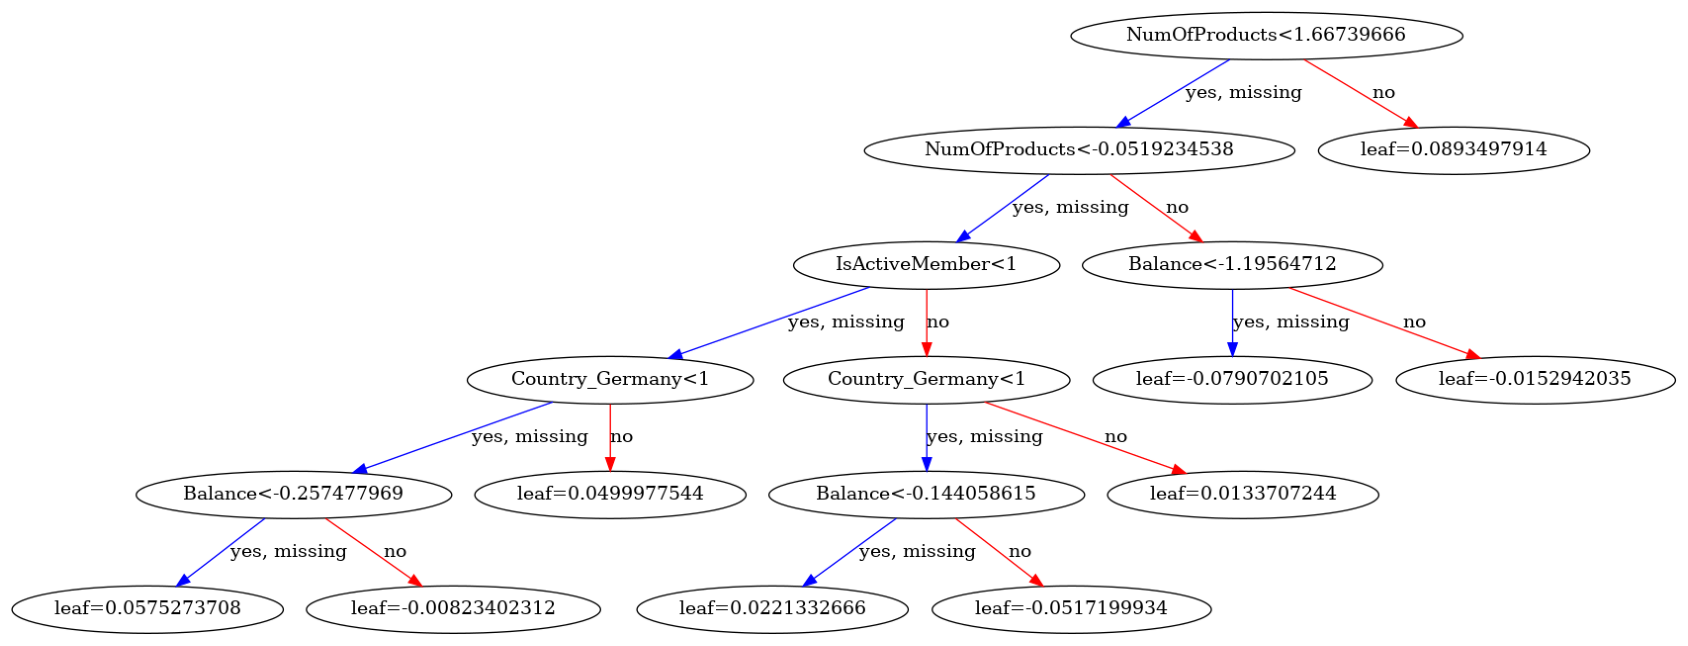

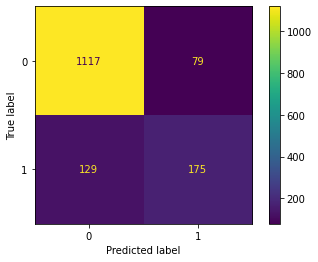

In [95]:
#бустинг на исходном датасете (несбалансированном)
XGBC_base = XGBClassifier(learning_rate = 0.1, verbosity = 1, objectve = 'binary:logistic', n_jobs = -1,\
                          scale_pos_weight = 0.7)
XGB_GS_base = GridSearchCV(
        XGBC_base,
        {
            'n_estimators': [22],
            'learning_rate': [0.1],
            'max_depth': [5],
            'booster': ['gbtree'],
            'min_child_weight': [2.0],
            #'scale_pos_weight': np.linspace(2.45, 2.55, num = 5),
            'reg_alpha': [0.05],#np.linspace(0.05, 0.15, num = 3),
            'reg_lambda': [0.1],#np.linspace(0.05, 0.15, num = 3),
            'gamma': [8.75],
            'subsample': [0.9],
            'colsample_bytree': [0.75]
        },
        scoring = 'roc_auc',
        n_jobs = -1,
        cv = 5,
        verbose = 4
)
XGB_GS_base.fit(X_original, y_original, sample_weight = Weights)
print("Наилучшие параметры:\n", XGB_GS_base.best_params_)
print(f"Best ROC AUC score: {XGB_GS_base.best_score_}")
print(f"ROC AUC score на out-of-sample данных: {roc_auc_score(y_test, XGB_GS_base.predict_proba(X_test)[:,1])}")
fig = px.histogram(x = XGB_GS_base.predict_proba(X_test)[:, 1], title = "Real minus predicted prob")
fig.show()
fig, ax = plt.subplots(figsize=(30, 50))
plot_tree(XGB_GS_base.best_estimator_, num_trees = 21, ax=ax)
fig = plt.gcf()
#fig.set_size_inches(30, 30)
plt.show()
plot_confusion_matrix(XGB_GS_base.best_estimator_, X_test, y_test)  
plt.show()  

In [96]:
#проведём последовательность тестирований для дальнейшей статистической проверки
metrics1 = []
for ind in indices:
    X_stat = X_test.iloc[ind, : ]
    y_stat = y_test.iloc[ind]
    metrics1.append(roc_auc_score(y_stat, XGB_GS_base.best_estimator_.predict_proba(X_stat)[:, 1]))
metrics1.sort()
metrics1

[0.8224531615925059,
 0.8351426799007444,
 0.8401124338624338,
 0.8434585027505381,
 0.8585093167701863,
 0.8657083657083656,
 0.8786549707602339,
 0.8866666666666666,
 0.890707671957672,
 0.914882081865004]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'gamma': 8.75, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2.65, 'n_estimators': 50, 'reg_alpha': 0.05, 'reg_lambda': 0.04, 'subsample': 0.9}
Best ROC AUC score: 0.9211295424103211
ROC AUC score на out-of-sample данных: 0.8706337462594614


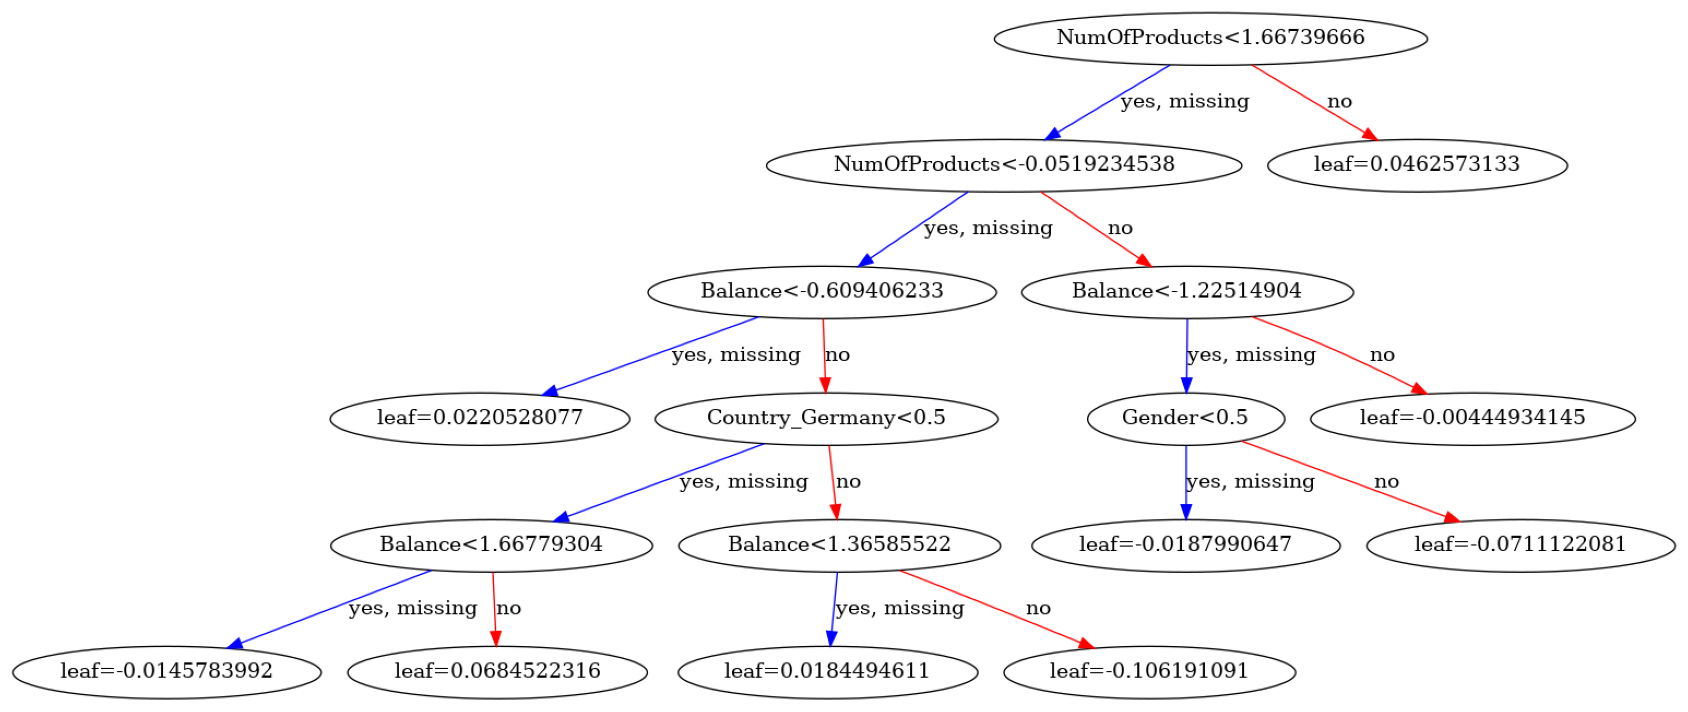

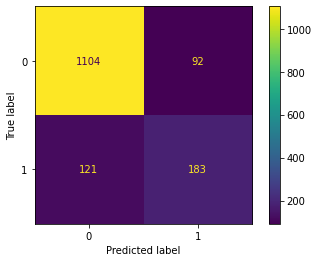

In [97]:
#бустинг на сбалансированном (oversampled) датасете
XGBC = XGBClassifier(learning_rate = 0.05, verbosity = 1, objectve = 'binary:logistic', n_jobs = -1,\
                          scale_pos_weight = 0.7)
XGB_GS = GridSearchCV(
        XGBC,
        {
            'n_estimators': [50],
            'learning_rate': [0.1],
            'max_depth': [5],
            'booster': ['gbtree'],
            'min_child_weight': [2.65],
            #'scale_pos_weight': np.linspace(2.45, 2.55, num = 5),
            'reg_alpha': [0.05],#np.linspace(0.05, 0.07, num = 3),
            'reg_lambda': [0.04],#np.linspace(0.035, 0.045, num = 3),
            'gamma': [8.75],
            'subsample': [0.9],
            'colsample_bytree': [0.75]
        },
        scoring = 'roc_auc',
        n_jobs = -1,
        cv = 5,
        verbose = 4
)
XGB_GS.fit(X_oversampled, y_oversampled)
print(XGB_GS.best_params_)
print(f"Best ROC AUC score: {XGB_GS.best_score_}")
print(f"ROC AUC score на out-of-sample данных: {roc_auc_score(y_test, XGB_GS.predict_proba(X_test)[:,1])}")
fig = px.histogram(x = XGB_GS.predict_proba(X_test)[:, 1], title = "Real minus predicted prob")
fig.show()
fig, ax = plt.subplots(figsize=(30, 50))
plot_tree(XGB_GS.best_estimator_, num_trees = 49, ax=ax)
fig = plt.gcf()
#fig.set_size_inches(30, 30)
plt.show()
plot_confusion_matrix(XGB_GS.best_estimator_, X_test, y_test)  
plt.show() 

In [98]:
#проведём последовательность тестирований для дальнейшей статистической проверки
metrics2 = []
for ind in indices:
    X_stat = X_test.iloc[ind, : ]
    y_stat = y_test.iloc[ind]
    metrics2.append(roc_auc_score(y_stat, XGB_GS.best_estimator_.predict_proba(X_stat)[:, 1]))
metrics2.sort()
metrics2

[0.8227459016393442,
 0.8258374689826303,
 0.8376322751322751,
 0.8404687873714423,
 0.8652173913043478,
 0.8720538720538721,
 0.8901072124756335,
 0.8951719576719577,
 0.918888888888889,
 0.9311466522092708]

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Наилучшие параметры:
 {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100}
Best ROC AUC score: 0.8584713066577283
ROC AUC score на out-of-sample данных: 0.8660543368245027


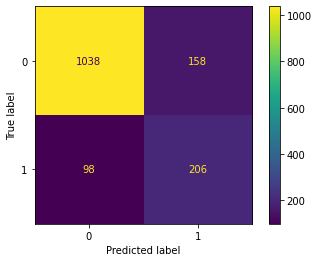

In [99]:
#случайный лес на исходном датасете (несбалансированном)
RFC_base = RandomForestClassifier(max_features = 'auto', n_jobs = -1, class_weight = 'balanced_subsample')
RFC_GS_base = GridSearchCV(
        RFC_base,
        {
            'n_estimators': [100],
            'max_depth': [8],
            'criterion': ['gini', 'entropy']
        },
        scoring = 'roc_auc',
        n_jobs = -1,
        cv = 10,
        verbose = 4
)
RFC_GS_base.fit(X_original, y_original)
print("Наилучшие параметры:\n", RFC_GS_base.best_params_)
print(f"Best ROC AUC score: {RFC_GS_base.best_score_}")
print(f"ROC AUC score на out-of-sample данных: {roc_auc_score(y_test, RFC_GS_base.predict_proba(X_test)[:,1])}")
fig = px.histogram(x = RFC_GS_base.predict_proba(X_test)[:, 1])
fig.show()
plot_confusion_matrix(RFC_GS_base.best_estimator_, X_test, y_test)  
plt.show() 

In [100]:
#проведём последовательность тестирований для дальнейшей статистической проверки
metrics3 = []
for ind in indices:
    X_stat = X_test.iloc[ind, : ]
    y_stat = y_test.iloc[ind]
    metrics3.append(roc_auc_score(y_stat, RFC_GS_base.best_estimator_.predict_proba(X_stat)[:, 1]))
metrics3.sort()
metrics3

[0.8170374707259953,
 0.8232009925558312,
 0.8330026455026455,
 0.8354460655345611,
 0.8598757763975156,
 0.8660968660968661,
 0.8820662768031189,
 0.8974867724867724,
 0.9133333333333333,
 0.9238275955543508]

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Наилучшие параметры:
 {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 40}
Best ROC AUC score: 0.8790834288252409
ROC AUC score на out-of-sample данных: 0.8587520352930822


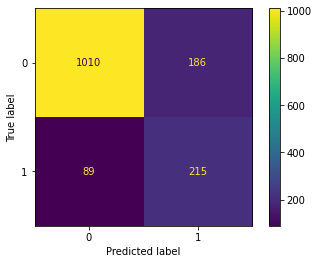

In [101]:
#случайный лес на сбалансированном (oversampled) датасете
RFC = RandomForestClassifier(max_features = 'auto', n_jobs = -1)
RFC_GS = GridSearchCV(
        RFC,
        {
            'n_estimators': [40],
            'max_depth': [6],
            'criterion': ['gini', 'entropy']
        },
        scoring = 'roc_auc',
        n_jobs = -1,
        cv = 5,
        verbose = 4
)
RFC_GS.fit(X_oversampled, y_oversampled)
print("Наилучшие параметры:\n", RFC_GS.best_params_)
print(f"Best ROC AUC score: {RFC_GS.best_score_}")
print(f"ROC AUC score на out-of-sample данных: {roc_auc_score(y_test, RFC_GS.predict_proba(X_test)[:, 1])}")
fig = px.histogram(x = RFC_GS.predict_proba(X_test)[:, 1])
fig.show()
plot_confusion_matrix(RFC_GS.best_estimator_, X_test, y_test)  
plt.show() 

In [102]:
#проведём последовательность тестирований для дальнейшей статистической проверки
metrics4 = []
for ind in indices:
    X_stat = X_test.iloc[ind, : ]
    y_stat = y_test.iloc[ind]
    metrics4.append(roc_auc_score(y_stat, RFC_GS.best_estimator_.predict_proba(X_stat)[:, 1]))
metrics4.sort()
metrics4

[0.7972775175644028,
 0.8263354037267081,
 0.8272332506203474,
 0.8389550264550265,
 0.8484812245874194,
 0.8637658637658638,
 0.8835978835978838,
 0.891388888888889,
 0.8944931773879142,
 0.9211168338303063]

In [103]:
#выберем между двумя моделями бустинга
XGB_metrics = TestStatSignif(metrics1, metrics2)

#выберем между двумя моделями сдучайного леса
RF_metrics = TestStatSignif(metrics3, metrics4)

#выберем между моделью бустинга и случайного леса
Final_metrics = TestStatSignif(XGB_metrics, RF_metrics)

print(Final_metrics)


#Таким образом, стоит выбрать градиентый бустинг, обученный на oversampled данных

Выборки похожи
Выборки похожи
Выборки различаются
[0.8227459016393442, 0.8258374689826303, 0.8376322751322751, 0.8404687873714423, 0.8652173913043478, 0.8720538720538721, 0.8901072124756335, 0.8951719576719577, 0.918888888888889, 0.9311466522092708]
